## AI Pump Health Monitor

 Loading trained models...
 Models loaded. Operational cutoff threshold: -0.0213


   PREDICTIVE MAINTENANCE REPORT (AI)    


 STATUS: CRITICAL FAILURE DETECTED
     First Signal (Preventive) : 2025-03-23 04:00:00
     Potential AI Failure      : 2025-03-28 08:00:00
     GAINED REACTION TIME      : 5.2 DÍAS
    (124 Hours of operational lead time)
      ROOT CAUSE :
   1. Vibration_g     ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 85.7%
   2. Motor_Temp_C    ▓ 9.4%
   3. Amperage_A       2.4%


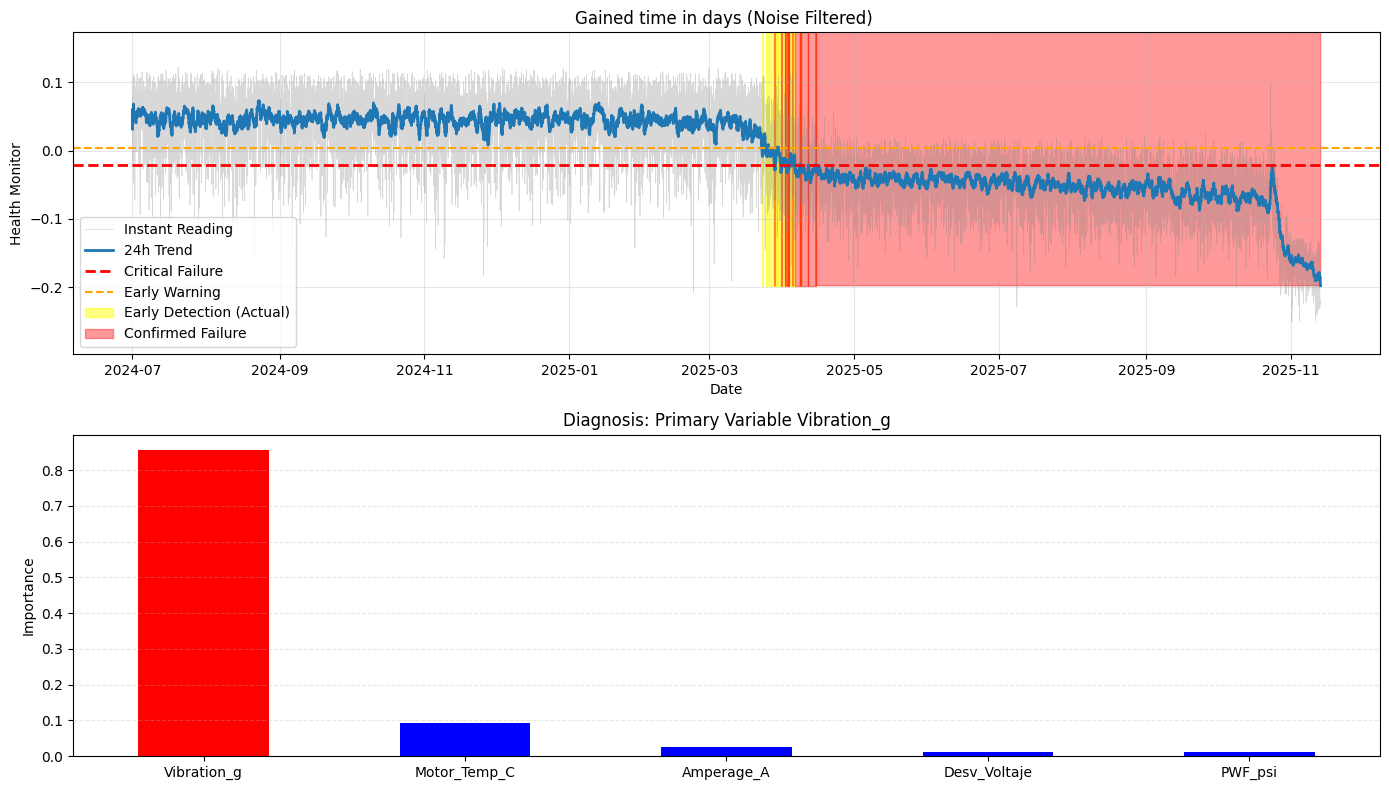

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import joblib

# 1. Load Data
df_esp = pd.read_csv('Data/Data_esp_failure.csv')
df_esp['Date'] = pd.to_datetime(df_esp['Date'])

print(" Loading trained models...")
try:
    # --- Model Loading ---
    iso_forest = joblib.load('ESP_IA.joblib')
    config = joblib.load('configuracion_IA.pkl')
    umbral_operativo = config['umbral_corte']
    cols_modelo = config['columnas_entrenamiento']
    print(f" Models loaded. Operational cutoff threshold: {umbral_operativo:.4f}")
except FileNotFoundError:
    print(" Error: .joblib or .pkl files not found. Run the training first..")
    exit()

# 2. Data Preprocessing
# Working on a copy to avoid affecting the original
df_falla = df_esp.copy()

# Replicate exact feature engineering
df_falla['Desv_Voltaje'] = np.abs(480 - df_falla['Voltage_V'])
X_falla = df_falla[cols_modelo]

# 3. Anomaly Detection  

# A. Calculate Raw Score (Indispensable initial step)
scores_nuevos = iso_forest.decision_function(X_falla)
df_falla['Score_Salud'] = scores_nuevos

# B. Calculate Smoothed Score (CRITICAL: DO IT BEFORE DETECTION)
# Use the same 24h window used to train the threshold
df_falla['Score_Suavizado'] = df_falla['Score_Salud'].rolling(window=24, min_periods=1).mean()

# C. Define the alert BEFORE generating the report
umbral_alerta = umbral_operativo + 0.025

# D. Apply the correct rule
# Comparing 'Smoothed vs. Smoothed Threshold"
# This eliminates instantaneous noise from the mathematical decision
df_falla['Anomalia_IA'] = np.where(df_falla['Score_Suavizado'] < umbral_operativo, 1, 0)

# 4. Results Report 
total_horas = len(df_falla)
horas_anormales = df_falla['Anomalia_IA'].sum()
dias_ganados = 0.0 # Ini

print("\n" )
print("   PREDICTIVE MAINTENANCE REPORT (AI)    ")
print( "\n")

if horas_anormales == 0:
    print(" STATUS: HEALTHY (GREEN)")
    print("   The equipment is operating within design parameters")
    culpable_principal = None 
else:
    print(" STATUS: CRITICAL FAILURE DETECTED")
    
    # Key Dates
    inicio_falla = df_falla.loc[df_falla['Score_Suavizado'] <= umbral_operativo, 'Date'].min()
    
    # Finding the first moment it crossed the statistical threshold
    inicio_alerta = df_falla.loc[
        (df_falla['Score_Suavizado'] <= umbral_alerta) & 
        (df_falla['Score_Suavizado'] > umbral_operativo), 
        'Date'
    ].min()
    
    # If there was no previous alert (sudden failure), the alert is the same moment as the failure
    if pd.isnull(inicio_alerta):
        inicio_alerta = inicio_falla

    # Calculation of Lead Time Gained
    tiempo_ganado = inicio_falla - inicio_alerta
    horas_ganadas = tiempo_ganado.total_seconds() / 3600
    dias_ganados = horas_ganadas / 24

    # Calculation of Remaining Useful Life (Lead Time)
    if pd.notnull(inicio_alerta) and pd.notnull(inicio_falla):
        tiempo_reaccion = inicio_falla - inicio_alerta

# 5. High-Impact Metrics Display
    print("="*45 )
    print(f"     First Signal (Preventive) : {inicio_alerta}")
    print(f"     Potential AI Failure      : {inicio_falla}")
    print( "="*45)
    print(f"     GAINED REACTION TIME      : {dias_ganados:.1f} days")
    print(f"    ({horas_ganadas:.0f} Hours of operational lead time)")
    print("="*45 )
# 6. Integrated Diagnosis 
    print("      ROOT CAUSE :")
    clf_diagnostico = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_diagnostico.fit(X_falla, df_falla['Anomalia_IA'])
    
    importancias = pd.Series(clf_diagnostico.feature_importances_, index=cols_modelo).sort_values(ascending=False)
    culpable_principal = importancias.index[0]
    
    # Showing the top 3 with clean formatting
    for i, (col, imp) in enumerate(importancias.head(3).items(), 1):
        barra = "▓" * int(imp * 20)
        print(f"   {i}. {col:<15} {barra} {imp:.1%}")


# 6. Clean Final Visualization (Noise-free) 

plt.figure(figsize=(14, 8))

#  CHART 1: Health Monitor 
plt.subplot(2, 1, 1)

# A. Plot Raw Score 
plt.plot(df_falla['Date'], df_falla['Score_Salud'], color='gray', alpha=0.3, linewidth=0.5, label='Instant Reading')

# B. Plot TREND 
plt.plot(df_falla['Date'], df_falla['Score_Suavizado'], label='24h Trend', color='#1f77b4', linewidth=2)

# C. Plot Threshold Lines
plt.axhline(umbral_operativo, color='red', linestyle='--', linewidth=2, label='Critical Failure')
plt.axhline(umbral_alerta, color='orange', linestyle='--', linewidth=1.5, label='Early Warning')

# D. Fill Logic 

# Yellow fill
plt.fill_between(df_falla['Date'], df_falla['Score_Suavizado'].min(), 0.5, 
                 where=(df_falla['Score_Suavizado'] <= umbral_alerta) & (df_falla['Score_Suavizado'] > umbral_operativo),
                 color='yellow', alpha=0.5, label='Early Detection (Actual)')

# Red fill
plt.fill_between(df_falla['Date'], df_falla['Score_Suavizado'].min(), 0.5, 
                 where=(df_falla['Score_Suavizado'] <= umbral_operativo),
                 color='red', alpha=0.4, label='Confirmed Failure')

# Dynamic Y-axis Scaling
plt.ylim(df_falla['Score_Suavizado'].min() - 0.1, df_falla['Score_Suavizado'].max() + 0.1)

plt.title(f'Gained time in days (Noise Filtered) ')
plt.ylabel('Health Monitor')
plt.xlabel('Date')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# CHART 2: Diagnosis 
if horas_anormales > 0:
    plt.subplot(2, 1, 2)
    colores_barras = ['red' if var == culpable_principal else 'blue' for var in importancias.index]
    importancias.plot(kind='bar', color=colores_barras)
    plt.title(f'Diagnosis: Primary Variable {culpable_principal}')
    plt.ylabel('Importance')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()